# Assignment 4 
# Trading Strategy using Time-Series Forecast

---
In this assignment, we will develop a trading strategy using the time-series forecast techniques. 



I will help you develop idea by showing with simple ARIMA model method. 

1. First, we will download necessary library

In [6]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Download historical price. Here, I used the historical gold price in USD.


In [7]:
df_gold = data.DataReader(f"GC=F", "yahoo", "2015-01-01", "2020-12-31") 
df_gold = df_gold.resample('24h').ffill()
gold_close = df_gold.Close
log_gold = np.log(gold_close)
train_gold = log_gold[:"2019-12-31"]
test_gold  = log_gold["2020-01-01":]

Next, I need to find out the order of autoregressive. The PACF of log(p[t]) price is computed and show.

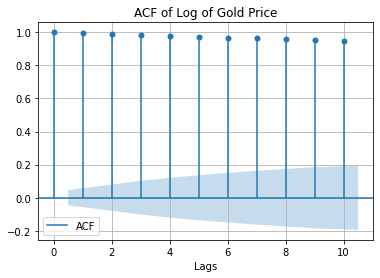

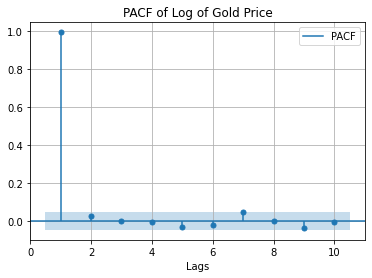

In [8]:
import statsmodels.api as sm
#plot
sm.graphics.tsa.plot_acf(train_gold, lags=10)
plt.title("ACF of Log of Gold Price")
plt.xlabel("Lags")
plt.legend(["ACF"])
plt.grid()
sm.graphics.tsa.plot_pacf(train_gold, lags=10, zero=False)
plt.title("PACF of Log of Gold Price")
plt.xlabel("Lags")
plt.legend(["PACF"])
plt.grid()

From PACF, I may need up to 1 lags.

Furthermore, I also investidate the difference version log(p[t]) - log(p[t-1]).


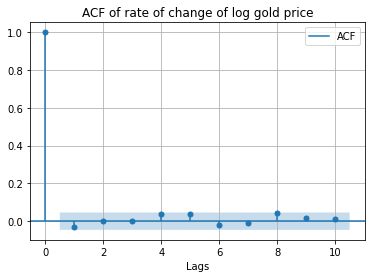

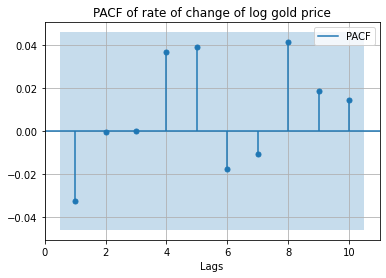

In [9]:
import statsmodels.api as sm
#plot
sm.graphics.tsa.plot_acf(train_gold.diff(1).dropna(), lags=10)
plt.title("ACF of rate of change of log gold price")
plt.xlabel("Lags")
plt.legend(["ACF"])
plt.grid()
sm.graphics.tsa.plot_pacf(train_gold.diff(1).dropna(), lags=10, zero=False)
plt.title("PACF of rate of change of log gold price")
plt.xlabel("Lags")
plt.legend(["PACF"])
plt.grid()

In case of log(p[t]) - log(p[t-1]), we may need only 0 lag step.

From PACF of log(p[t]) and log(p[t]) - log(p[t-1]), we can see that we probably need up to 1 lag only.To be safe, I will pick maximum lag to be 3, or for p=0,...,3 and q =0,...,3.

We develop a parameter search model.

In [10]:
import itertools    
import warnings
import statsmodels.tsa.arima_model as arima_model
warnings.filterwarnings("ignore")
def arimaParameterSearch(data, p_max, d_max, q_max):
  """
  ARIMA Parameter search function
  The goal is to search for the phi and theta in the 
  ARIMA model where 
  data: price time series data
  p_max: the maximum number of autoregressive terms (number of phis)
  d_max: the maximum number of differences 
  q_max:the maximum number of moving-average terms (number of phis)
  """

  p = range(p_max + 1)
  d = range(d_max+ 1)
  q = range(q_max+ 1)
  parameter_spaces = list(itertools.product(p, d, q))
  best_aic, pdq= None, None
  for (p, d, q) in parameter_spaces:   
    try :
      model = arima_model.ARIMA(data, order=(p,d,q))
      result = model.fit(method="mle")
      if (best_aic is None) or (result.aic < best_aic):
        
        best_aic = result.aic
        pdq = (p,d,q)
        print(pdq, best_aic)
    except:
      continue
  return best_aic, pdq

In [11]:
aic, pdq = arimaParameterSearch(train_gold, p_max=3, d_max=1, q_max=3)

(0, 0, 0) -4168.631906055971
(0, 0, 1) -6463.019532828979
(0, 0, 2) -8158.079089831026
(0, 0, 3) -9341.930271823567
(0, 1, 0) -13080.471328730495
(1, 0, 0) -13081.664977485987
(3, 1, 3) -13083.856876410005


We train the model based on the computed p, d, q


In [12]:
print(f"The model is ARIMA{pdq}")
model = arima_model.ARIMA(train_gold, order=pdq)
result = model.fit(method="mle")
print(result.summary())

The model is ARIMA(3, 1, 3)
                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1826
Model:                 ARIMA(3, 1, 3)   Log Likelihood                6549.928
Method:                           mle   S.D. of innovations              0.007
Date:                Fri, 26 Mar 2021   AIC                         -13083.857
Time:                        10:13:26   BIC                         -13039.778
Sample:                    01-01-2015   HQIC                        -13067.597
                         - 12-31-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0001      0.000      0.892      0.372      -0.000       0.000
ar.L1.D.Close    -0.0866      0.096     -0.898      0.369      -0.275       0.102
ar.L2.D.Clos

Next step is to create the forecaster using ARIMA model given above

In [13]:
from scipy.stats import norm 
def difference(data, interval=1):
  """
  create time different y[t] - y[t - interval]
  data: time-series data
  interval: time lag 
  Return 
      y[t] - y[t - interval]
  """
  return data - data.shift(interval)
def integrate(diff_y, hist_data, interval=1):
  """
  inverse version of time difference function
  diff_y: time-series of y[t] - y[t - interval]
  hist_data: time-series of y[t - interval]
  Return
    y[t] + y[t - interval]
  """
  return diff_y + hist_data.shift(interval)

def buildARIMAForecast(phis, theta, d, mu, sigma=0):
  """
  Create the ARIMA forecast function
  y[t] = mu + phi_1*y[t-1]+...+phi_p*y[t-p] + w[t] 
         + theta_1*w[t-1] + ...+theta_q * w[t-q]
  Inputs
    phis: array of autregressive parameters [phi_1, phi_2, .... phi_p]
    theta: array of moving average parameters [theta_1, ..., theta_q]
    d: difference order Ex: d=0, we work with y[t] = p[t], d=1, 
        we work with y[t] =p[t] - p[t-1]
    mu: mu parameter is the model
    sigma: standard deviation of forecasting error. 
  Return:
    ARIMA forecast function
  """

  p = len(phis)
  q = len(theta)
  def arimaForecast(data, alpha=0.95, res0=0):
    """
    arima 1-step forecast function
    y[t] = mu + phi_1*y[t-1]+...+phi_p*y[t-p] + w[t] 
         + theta_1*w[t-1] + ...+theta_q * w[t-q]
    Input:
      data: time-series data that we want to perform forecast
      alpha: where 1- alpha is confidence level 
      res0: initial residue. 
    Return:
      x_pred: 1-step predicted prices
      residue: forecast residue error.
      [conf_int_low, conf_int_high]: list containting lower and upper confidence intervals
    """
    x = data.copy()
    if d > 0: # d > 0, we work with differences
      for k in range(d): # difference orders
        x = difference(x, interval=1)
    x = x.dropna() # drop unusable data. 
    num_x = x.shape[0]
    pq_max = max(p,q) # maximum between autoregressive and moving average
    residue = np.zeros((num_x,))
    residue[:pq_max] = res0 # initialized residues
    x_out = [] # for storing forecast values
    dates = [] # for storing dates where we have forecast values 
    for k in range(pq_max, num_x): # for each day
      x_pred = mu # y_hat[t] = mu
      if p > 0:
        x_hist = (x.iloc[k-p:k] - mu) #y[t-1],.., y[t-p]
        x_pred += (phis * x_hist).sum()        
        # y_hat[t] = y_hat[t] + phi_1*y[t-1]+...+phi_p*y[t-p] + w[t] 
      if q > 0:
        w_hist = residue[k-q:k] #w[t], ..., w[t-q]
        x_pred += (theta * w_hist).sum()
        #y_hat[t] += y_hat[t] + theta_1*w[t-1] + ...+theta_q * w[t-q]     
      x_out.append(x_pred)
      dates.append(x.index[k])

      ## update residue 
      residue[k] = x.iloc[k] - x_pred #w[t] = y[t] -  y_hat[t]
    x_pred = pd.Series(x_out, index=dates) # Covert to time series
    residue = pd.Series(residue[pq_max:], index=dates) # Covert to time series
    if d > 0:
      for k in range(d):
        x_pred = integrate(x_pred, data).dropna()
    # make confidence intervale
    zalpha2 = norm.ppf(1 - alpha/2) # compute z_{alpha/2}
    conf_int_high = x_pred + zalpha2 * sigma # upper 95% confidence
    conf_int_low = x_pred - zalpha2 * sigma # lower 95% confidence 
    return x_pred, residue , [conf_int_low, conf_int_high]
  return arimaForecast 


Next, we need to extract parameters from the ARIMA model

In [14]:
try:
  theta = result.maparams
except:
  theta = np.array([])
try:
  phi = result.arparams
except:
  phi = np.array([])
mu = result.params['const']
d = pdq[1]
print(f"d: {d}")
print(r"thata: {}".format(theta))
print(r"phi: {}".format(phi))
print(f"Mu: {mu} ")
forecast_vol_sigma = result._forecast_error(steps=1)
print(f"1 Step forecast has STD: {forecast_vol_sigma}")

d: 1
thata: [0.04934582 0.06656444 0.90294899]
phi: [-0.08656004 -0.08367438 -0.89541537]
Mu: 0.0001366611117110215 
1 Step forecast has STD: [0.00669757]


In [15]:
arima_gold = buildARIMAForecast(phi, theta, d=d, mu=mu, sigma=forecast_vol_sigma[0])

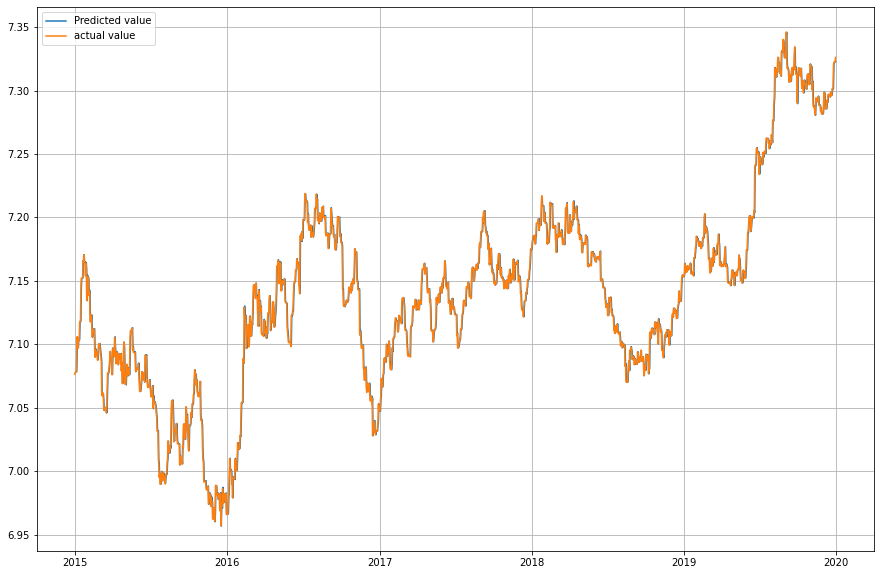

In [16]:
pred_gold, resid, confidence_int = arima_gold(train_gold, alpha=.01) # 99.5% confidence
plt.figure(figsize=(15,10))
plt.plot(pred_gold)
plt.plot(train_gold)
plt.grid()
plt.legend(["Predicted value", "actual value"])

Next step, we need to develop an indicator.
Here, we will buy if the close price is higher that than the higher confidence value of the forecast.
We will sell if our buy price is lower than the lower confidence value.

In [17]:
def buildARIMAIndicator(price,  confidence_interval, is_plot=False):
  """
  Trading using ARIMA Forecast:
  Inputs: 
          price: pandas time-series of the prices. 
          confidence_interval: list of two time-series of the lower and upper confidence values of predicted price
          is_plot: If true, this code will plot the Adj close price and show the buy and sell points.
  output:
          signal indicator: the series of indicators 1 to take the position, 0 for keep previous status and -1 to clear the position.

  """

  conf_low = confidence_interval[0]
  conf_high = confidence_interval[1]
  signal = []
  status = 0 #0==> no position, 1==>  buy all
  buy_price = 0
  for k in range(price.shape[0]):
    date = price.index[k]    
    if date in conf_low.index:      
      # only on the dates where we have confidence interval
      if (price[date] > conf_high[date]) and (status == 0): 
        # buy only when the close price is higher than upper part of the confidence
        # interval 
        # Basically, we are sure that the price siginificantly up.
        signal.append(1) # signal = 1 ==> buy
        status = 1
        buy_price = price[date]
        print(f"{date} Buy at {buy_price}.")

      elif (buy_price >  conf_low[date]) and (status == 1): 
        # sell only when the buy price is higher than higher part of the confidence
        # Basically, we are sure that the price really going down
        signal.append(-1) #signal = -1 ==> sell       
        status = 0   
        print(f"{date} Sell at {price[date]}")
      else:
        signal.append(0) # signal = 0 ==> do not thing.
    else:
      signal.append(0)

  signal = pd.Series(data=signal, index=price.index)
  buy_sig = price[signal == 1]
  sell_sig = price[signal == -1]
  if is_plot:
    plt.figure(figsize=(15,10))
    plt.plot(price)
    plt.plot(conf_high)
    plt.plot(conf_low) 
    plt.plot(buy_sig, color="red", marker="^",linestyle="")   
    plt.plot(sell_sig, color="black", marker="v",linestyle="")  
    plt.legend(["Adj Close","High", "Low", "Buy", "Sell"])
    plt.title("Bollinger Bands")
    plt.grid()
  return signal

2015-01-15 00:00:00 Buy at 7.142590180277465.
2015-01-16 00:00:00 Sell at 7.152190563550428
2015-01-30 00:00:00 Buy at 7.153442794731241.
2015-01-31 00:00:00 Sell at 7.153442794731241
2015-04-01 00:00:00 Buy at 7.096804136316874.
2015-04-02 00:00:00 Sell at 7.090826574996442
2015-04-27 00:00:00 Buy at 7.0928231020226296.
2015-04-28 00:00:00 Sell at 7.101675971619444
2015-05-13 00:00:00 Buy at 7.1052938216187576.
2015-05-14 00:00:00 Sell at 7.111022620214896
2015-06-18 00:00:00 Buy at 7.091326055176523.
2015-06-19 00:00:00 Sell at 7.091326055176523
2015-08-20 00:00:00 Buy at 7.050122520269059.
2015-08-21 00:00:00 Sell at 7.055830375993635
2015-09-18 00:00:00 Buy at 7.037115462836247.
2015-09-19 00:00:00 Sell at 7.037115462836247
2015-09-24 00:00:00 Buy at 7.050816164142189.
2015-09-25 00:00:00 Sell at 7.044032897274685
2015-10-02 00:00:00 Buy at 7.036236419160215.
2015-10-03 00:00:00 Sell at 7.036236419160215
2015-12-04 00:00:00 Buy at 6.988874330266929.
2015-12-05 00:00:00 Sell at 6.98

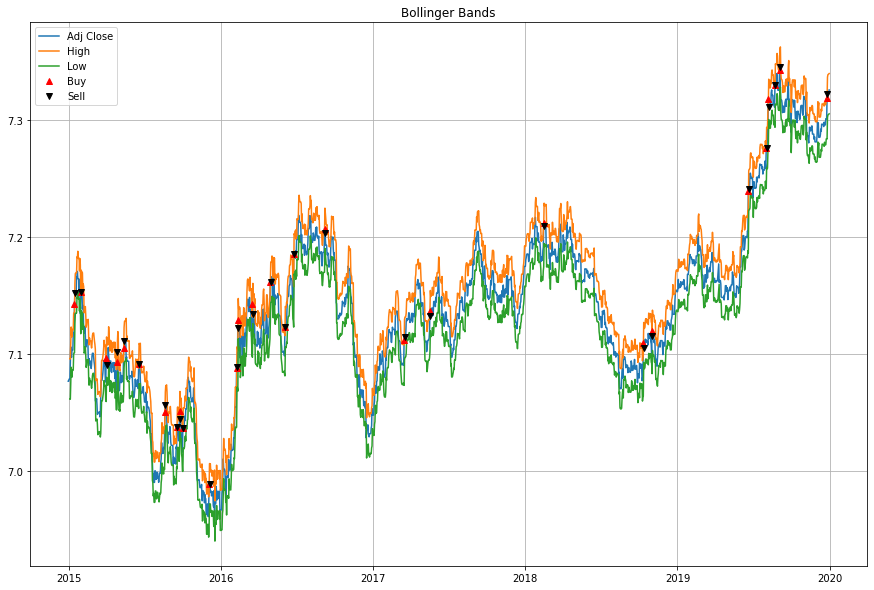

In [18]:
indicator_train = buildARIMAIndicator(train_gold, confidence_int, is_plot=True)

Next, we want to trade using this indicator

In [19]:
def techicalTrading(price, # dataframe of a stock
                    indicator, # trade indicator
                    initial_money=1000000 #Starting money
                    ):
  """
  Trader simulation:
  Inputs: 
        price: time series of prices
        indicator: time-series indicator: 1 for Buy, -1 for sell, 0 for nothing
        initinal_money: initial money in the port. default 1M 
  output:
        wealth: time-series money in the port
  """

  num_dates = price.shape[0]
  status = "NONE" # Start with no poistion
  stock= 0
  money = initial_money
  wealth = []

  for k in range(num_dates):
    indicatork = indicator[k]
    if not np.isnan(indicatork): # if it is not NA
      if (indicatork > 0) and ( status == "NONE"):
        stock = money/price.iloc[k]
        #print(f"Buy at {close.values[k]}")
        money = 0
        status = "HOLD"
      elif (indicatork < 0) and ( status == "HOLD"):
        money = stock * price.iloc[k]
        stock =  0
        #print(f"Sell at {close.values[k]}")
        status = "NONE"
    cur_wealth = money + stock * price.iloc[k]
    wealth.append(cur_wealth)
  wealth = pd.Series(data=wealth, index=price.index)  
  return wealth 

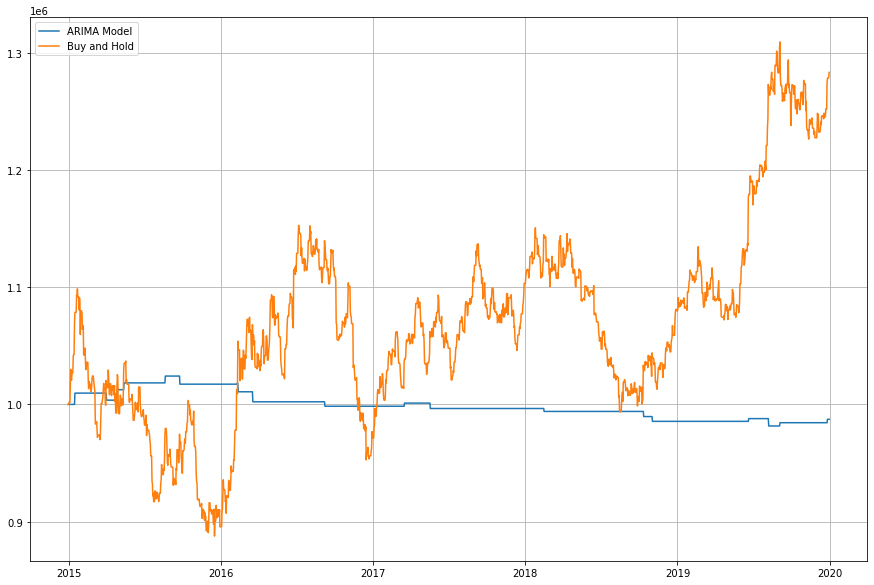

In [20]:
gold_price_train = np.exp(train_gold) # convert back the acutal price
wealth_train = techicalTrading(gold_price_train, indicator_train, initial_money=1000000)
indicator_buy_hold = indicator_train *0 
indicator_buy_hold[0] = 1
wealth_buy_and_hold = techicalTrading(gold_price_train, indicator_buy_hold, initial_money=1000000)
plt.figure(figsize=(15,10))
plt.plot(wealth_train)
plt.plot(wealth_buy_and_hold)
plt.grid()
plt.legend(["ARIMA Model", "Buy and Hold"])


Check for any differences

In [21]:
print(f"Final wealth using Buy and Hold: {wealth_buy_and_hold.iloc[-1]:,.2f}")
print(f"Final wealth using ARIMA: {wealth_train.iloc[-1]:,.2f}")

Final wealth using Buy and Hold: 1,283,469.86
Final wealth using ARIMA: 987,307.17


Working with test set

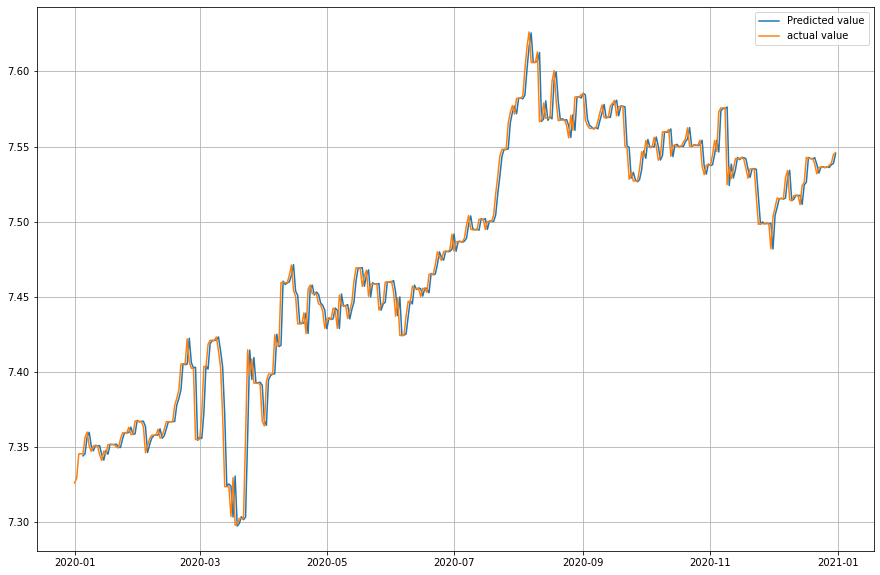

In [22]:
pred_gold_test, resid_test, confidence_int_test = arima_gold(test_gold, alpha=0.01) # 99% Confidence
plt.figure(figsize=(15,10))
plt.plot(pred_gold_test)
plt.plot(test_gold)
plt.grid()
plt.legend(["Predicted value", "actual value"])

2020-02-21 00:00:00 Buy at 7.40525245769181.
2020-02-22 00:00:00 Sell at 7.40525245769181
2020-03-03 00:00:00 Buy at 7.403731174630206.
2020-03-04 00:00:00 Sell at 7.403122012808937
2020-03-17 00:00:00 Buy at 7.329684129131238.
2020-03-18 00:00:00 Sell at 7.297971409379836
2020-03-23 00:00:00 Buy at 7.356918242356021.
2020-03-24 00:00:00 Sell at 7.414693326609945
2020-04-02 00:00:00 Buy at 7.393693741205039.
2020-04-03 00:00:00 Sell at 7.398602630144402
2020-04-06 00:00:00 Buy at 7.424761761823209.
2020-04-07 00:00:00 Sell at 7.417460304409149
2020-04-09 00:00:00 Buy at 7.459454067834147.
2020-04-10 00:00:00 Sell at 7.459454067834147
2020-04-22 00:00:00 Buy at 7.455124931683166.
2020-04-23 00:00:00 Sell at 7.4577824131178785
2020-05-07 00:00:00 Buy at 7.451125562582621.
2020-05-08 00:00:00 Sell at 7.444190182532612
2020-07-27 00:00:00 Buy at 7.565793282428515.
2020-07-28 00:00:00 Sell at 7.572862977402529
2020-08-17 00:00:00 Buy at 7.59337419312129.
2020-08-18 00:00:00 Sell at 7.600602

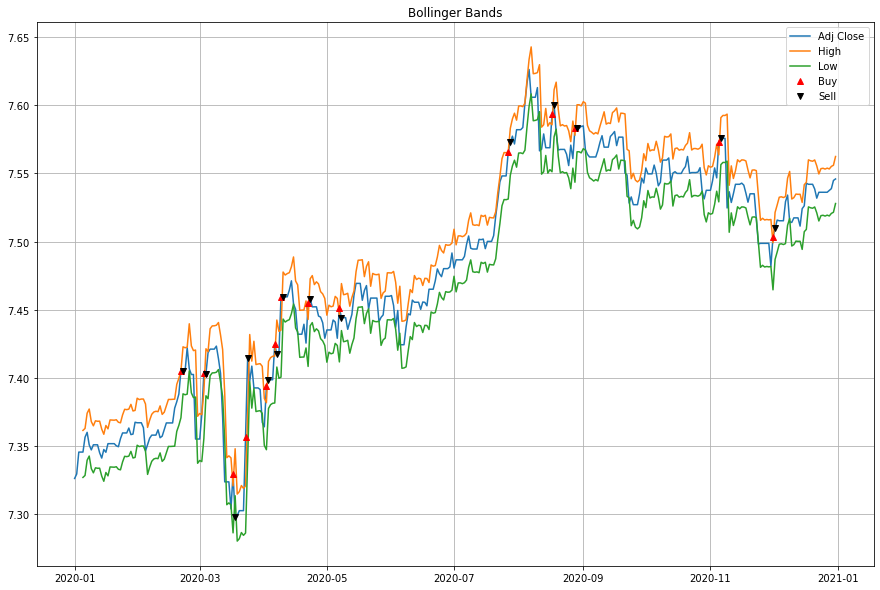

In [23]:
indicator_test = buildARIMAIndicator(test_gold, confidence_int_test, is_plot=True)

Text(0.5, 1.0, 'Wealth of Test set')

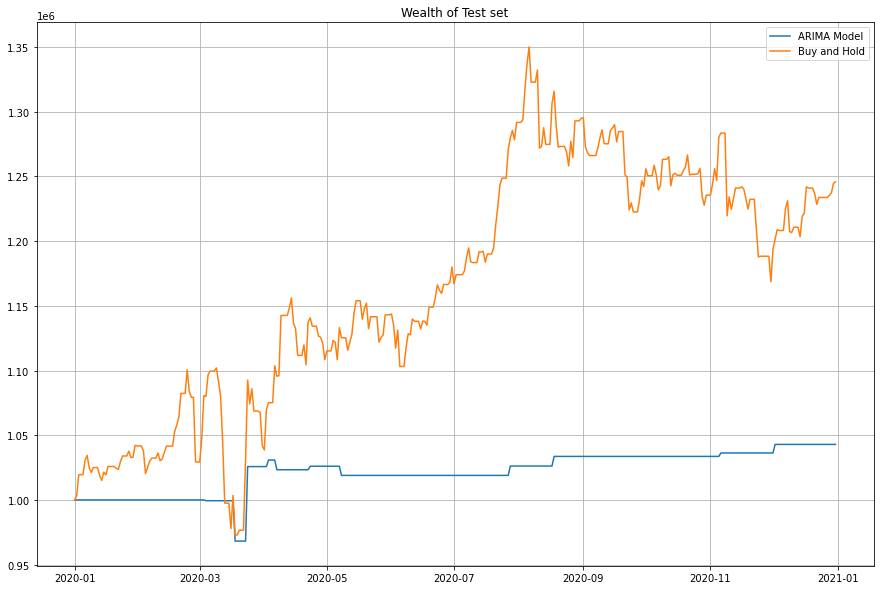

In [24]:
gold_price_test = np.exp(test_gold) # convert back the acutal price
wealth_test = techicalTrading(gold_price_test, indicator_test, initial_money=1000000)
indicator_buy_hold_test = indicator_test *0 
indicator_buy_hold[0] = 1
wealth_buy_and_hold_test = techicalTrading(gold_price_test, indicator_buy_hold, initial_money=1000000)
plt.figure(figsize=(15,10))
plt.plot(wealth_test)
plt.plot(wealth_buy_and_hold_test)
plt.grid()
plt.legend(["ARIMA Model", "Buy and Hold"])
plt.title("Wealth of Test set")

In [25]:
print(f"Final wealth using Buy and Hold: {wealth_buy_and_hold_test.iloc[-1]:,.2f}")
print(f"Final wealth using ARIMA: {wealth_test.iloc[-1]:,.2f}")

Final wealth using Buy and Hold: 1,245,870.34
Final wealth using ARIMA: 1,042,917.06


Now, I want to you creat a new strategy where you will buy at the trough and sell at the peak. Here the trough between $t-k$ and $t$ is defined as  $T_{t-k,t} = \min(p[t], p[t-1], ..., p[t-l])$. Similarly, we define the peak between $t-k$ and $t$ as $P_{t-k,t} = \max(p[t], p[t-1], ..., p[t-l])$.
If we are is the state = 0, or no position from $t-k$ to $t$ we will buy an assest at its trough, or when $T_{t-k,t} < c_l[t]$ where $c_l[t]$ is the lower confidence value of the forecast. Similarly, if we are in the state = 1, or hold the assest, we will sell and assest at its peak, or when $P_{t-k,t} > c_h[t]$ where $c_h[t]$ is the upper confidence value of the forecast.

if $T_{t-k,t} < c_l[t]$, we have $(1-\alpha/2)\%$ that the trough is really the trough, and if $P_{t-k,t} > c_h[t]$, we have $(1-\alpha/2)\%$ that the peak is really the peak.

In [26]:
#create a new indictor function here.

Determine the final wealth with train samples 

In [27]:
# your code is here

Determine the final wealth with train samples 

In [28]:
# your code is here.

Next, we want to construct the volatility model using ARCH(1) on the residue 
Thus, we have $Y_t = \mu_t + r_t$  where
$\mu_t$ is the forecast using ARIMA model that we used earlier, and
$r_t$ is the residue. 

First we need to install arch

In [29]:
!pip install arch 

In [31]:
from arch import arch_model
resid = result.resid
vol_model = arch_model(resid, mean="Constant", p=1, q=0, vol="arch")
result_vol = vol_model.fit()
print(result_vol.summary())



ModuleNotFoundError: No module named 'arch'

Now, please write the garch volatility forecast

$r_t = a_t$ \\
$\sigma_t^2 = \omega + \alpha\times\sigma_{t-1}^2 



In [ ]:
# your conde is here 
# look at the example in buildARIMAForecast 

def buildARCHVolForecast(omega, alpha):
   """
  Create the GARCH forecast function
  r[t] = a[t]
  sigma[t]^2 = omega + alpha * sigma[t-1]^2 
  omega and alpha are parameters for GARCH(1,1)
  Return:
    GARCH forecast function
  """
  def archForecast(y_arima, residue, confidence):
    """
      ARCH(1) forecasts
      Input:
      y_arima: time-series forecast from ARIMA
      residue: time-series forecast residue error 
      confidence: confidence level
    Return:
      x_pred: 1-step predicted prices
      sigma2: variance of forecast
      [conf_int_low, conf_int_high]: list containting lower and upper confidence intervals
    """
    x_pred = y_arima 
    # add your code here. Please note that x_pred = y_arima. 
  




Use this new confidence interval to trade using the peak, and trough strategy. 
Is there any differences in profit for confidence=0.99? zalpha2 = norm.ppf(confidence)

In [ ]:
# your code is here.

Lastly, let us try with difference confidence levels
Find wealths for confidence levels equal to 0.8 and 0.9999

In [ ]:
# your code is here. 

Which confidence level give you the maximum wealth for
1. trains samples
2. test samples 

In [ ]:
# you code is here